In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sunpy.map
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from astropy.coordinates import SkyCoord

In [6]:
iris_dir=  '/Users/domor/gazelle/demreg_FIP'
# width_map = sunpy.map.Map(f'{iris_dir}_wid_si1394_map.fits')
v_turb_map = sunpy.map.Map(f'{iris_dir}/fe12_intensity_maps/eis_2014_02_01__10_50_35_intensity.fits')
# hmi_map = sunpy.map.Map(f'{iris_dir}_hmi.fits')
# sis_map = sunpy.map.Map(f'{iris_dir}_sis_fip_bias_aligned.fits')
# pfss_pickle = f'{iris_dir}_pfss_fieldlines.pickle'
# fe_12_map = sunpy.map.Map(f'{iris_dir}_fe_12_195_12_aligned.fits')
# # Open and load the pickle file
# with open(pfss_pickle, 'rb') as file:
#     all_lines = pickle.load(file)

# with open(pfss_pickle, 'rb') as file:
#     fieldlines = pickle.load(file)



In [8]:
from iris_get_pfss_utils import get_pfss_from_map
fieldlines = get_pfss_from_map(v_turb_map, min_gauss=7, max_gauss=7,dimension = (1080, 510))


ModuleNotFoundError: No module named 'aiapy'

In [20]:
with open(f'{iris_dir}_pfss_fieldlines.pickle', 'wb') as f:
    pickle.dump(fieldlines, f)


In [9]:
# Define functions to change the observer time and frame
change_obstime = lambda x,y: SkyCoord(x.replicate(observer=x.observer.replicate(obstime=y), obstime=y))
change_obstime_frame = lambda x,y: x.replicate_without_data(observer=x.observer.replicate(obstime=y), obstime=y)


100%|██████████| 846/846 [00:04<00:00, 199.79it/s]


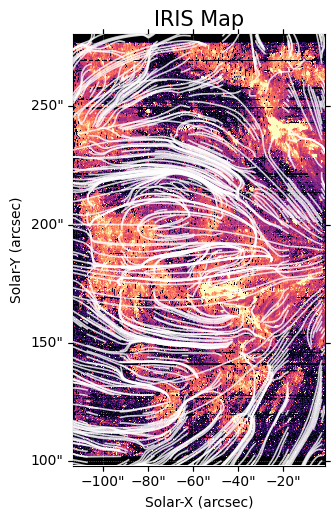

In [10]:
fig = plt.figure(figsize=(5,5))
for i,m in enumerate([width_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=0.25,cmap='magma')
    # m.plot()
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=15)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=10)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=10)
    ax.tick_params(axis='both', labelsize=10)
    # for c in tqdm(lines[::4]):
    #     ax.plot_coord(c, lw=3.3, color='white',alpha=.5)
    # for c in tqdm(long_lines[::2]):
    #     ax.plot_coord(c, lw=3.3, color='green',alpha=.8)
    for c in tqdm(fieldlines[::4]):
        coords = c.coords
        if coords.shape[0] > 0:  # Only plot if there are coordinates
            # Change the observer time of the coordinates to match the AIA map
            coords_updated = change_obstime(coords, m.date)
            ax.plot_coord(coords_updated, lw=1.2, color='white',alpha=.8)
    # for c in tqdm(long_lines[0]):
    #     ax.plot_coord(c, lw=5, color='black',alpha=.8)

    ax.axis(bounds)
# fig.savefig('Daves_IRIS_paper_PFSS.pdf',dpi=150)
plt.tight_layout(pad=0)
plt.show()

### Fieldline manipulations

In [12]:
# Import all functions useful for fieldline manipulations
from pfss_coords_manipulations import *

In [13]:
all_lines = [f.coords for f in fieldlines]
chromo_lines = []
coronal_lines = []
chromo2coronal_lines = []

chromo_height = 696700000
coronal_height = 700000000

In [14]:
# Find the locations of the fieldlines that are between the chromo and coronal heights
for f in all_lines:
    loc = find_locations(f.radius, min_height=chromo_height, max_height=coronal_height)
    if len(loc[0]) > 0:
        chromo_lines.append(skycoord_constructor(f, f.lon[loc], f.lat[loc], f.radius[loc]))

for f in all_lines:
    asc_loc, desc_loc = find_and_split_locations(f.radius, min_height=chromo_height, max_height=coronal_height)
    if asc_loc is not None and len(asc_loc) > 0:
        # Ascending part (from lower to higher height)
        chromo2coronal_lines.append(skycoord_constructor(f, f.lon[asc_loc], f.lat[asc_loc], f.radius[asc_loc]))
    if desc_loc is not None and len(desc_loc) > 0:
        # Descending part (from higher to lower height)
        chromo2coronal_lines.append(skycoord_constructor(f, f.lon[desc_loc], f.lat[desc_loc], f.radius[desc_loc]))


100%|██████████| 775/775 [00:03<00:00, 200.30it/s]


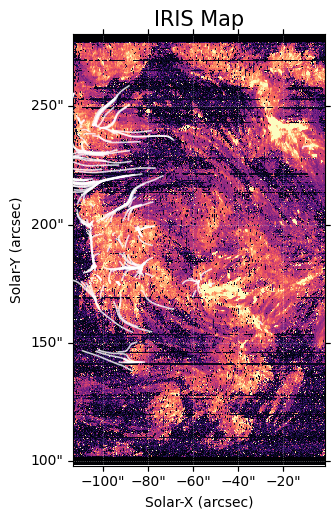

In [15]:
fig = plt.figure(figsize=(5,5))
for i,m in enumerate([width_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=0.25,cmap='magma')
    # m.plot()
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=15)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=10)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=10)
    ax.tick_params(axis='both', labelsize=10)
    # for c in tqdm(lines[::4]):
    #     ax.plot_coord(c, lw=3.3, color='white',alpha=.5)
    # for c in tqdm(long_lines[::2]):
    #     ax.plot_coord(c, lw=3.3, color='green',alpha=.8)
    for c in tqdm(chromo2coronal_lines[::2]):
        coords = c
        if coords.shape[0] > 0:  # Only plot if there are coordinates
            # Change the observer time of the coordinates to match the AIA map
            coords_updated = change_obstime(coords, m.date)
            ax.plot_coord(coords_updated, lw=1.2, color='white',alpha=.8)
    # for c in tqdm(long_lines[0]):
    #     ax.plot_coord(c, lw=5, color='black',alpha=.8)

    ax.axis(bounds)
# fig.savefig('Daves_IRIS_paper_PFSS.pdf',dpi=150)
plt.tight_layout(pad=0)
plt.show()

100%|██████████| 1550/1550 [00:21<00:00, 71.68it/s]


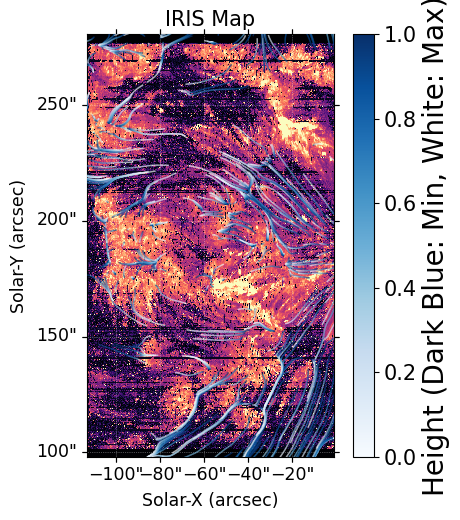

In [16]:
from matplotlib.collections import LineCollection

fig = plt.figure(figsize=(5,5))
for i,m in enumerate([width_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=0.25,cmap='magma')
    
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=15)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=12.5)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=12.5)
    ax.tick_params(axis='both', labelsize=12.5)
    
    for c in tqdm(chromo2coronal_lines):
        # Get the heights of the field line
        heights = c.radius.value
        
        # Normalize the heights to [0, 1] for colormapping
        norm_heights = (heights - heights.min()) / (heights.max() - heights.min())
        
        # Project the coordinates onto the map
        x, y = m.wcs.world_to_pixel(c)
        
        # Create a line collection for efficient plotting
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Use 'Blues_r' colormap to have dark blue at min height and white at max height
        lc = LineCollection(segments, cmap='Blues_r', norm=plt.Normalize(0, 1))
        lc.set_array(norm_heights)
        lc.set_linewidth(1)  # Reduced line width for better visibility
        
        ax.add_collection(lc)
    
    ax.axis(bounds)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Height')
    cbar.set_label('Height (Dark Blue: Min, White: Max)', fontsize=20)
    cbar.ax.tick_params(labelsize=15)

plt.tight_layout(pad=0)
plt.show()

In [24]:
blank_map = width_map
blind_map_data = np.zeros_like(blank_map.data)
coro_map_data = blind_map_data.copy()
# blank_map = sunpy.map.Map(np.zeros_like(blank_map.data), blank_map.wcs)
# for i,f in enumerate(chromo2coronal_lines):
#     chromo_pix = get_intersecting_pixels(f[0:2], width_map.wcs)[0]
    # coro_pix = get_intersecting_pixels(f[-3:-1], width_map.wcs)[-1]
import json

# Create a dictionary to store the mapping
chromo_to_coro_mapping = {}

for i, f in tqdm(enumerate(chromo2coronal_lines), total=len(chromo2coronal_lines)):
    chromo_pix = get_intersecting_pixels(f[0:2], width_map.wcs)[0]
    coro_pix = get_intersecting_pixels(f[-3:-1], width_map.wcs)[-1]

    # Check if the pixels are within the image bounds
    if (0 <= chromo_pix[0] < blind_map_data.shape[1] and 
        0 <= chromo_pix[1] < blind_map_data.shape[0] and
        0 <= coro_pix[0] < blind_map_data.shape[1] and 
        0 <= coro_pix[1] < blind_map_data.shape[0]):
        
        # Store the mapping
        chromo_key = f"{chromo_pix[0]},{chromo_pix[1]}"
        coro_value = f"{coro_pix[0]},{coro_pix[1]}"
        chromo_to_coro_mapping[chromo_key] = coro_value
        
        # Optionally, you can visualize this on the blank map
        blind_map_data[chromo_pix[1], chromo_pix[0]] += 1  # Mark chromospheric pixel
        coro_map_data[coro_pix[1], coro_pix[0]] += 1  # Mark coronal pixel

# After the loop, you can create maps from the data if needed
chromo_map = sunpy.map.Map(blind_map_data, width_map.wcs)
coro_map = sunpy.map.Map(coro_map_data, width_map.wcs)

# Print the number of mappings found
print(f"Number of chromosphere to corona mappings: {len(chromo_to_coro_mapping)}")

# Save the mapping to a JSON file
with open('chromo_to_coro_mapping.json', 'w') as f:
    json.dump(chromo_to_coro_mapping, f)

print("Mapping saved to chromo_to_coro_mapping.json")

1550it [00:45, 33.91it/s]

Number of chromosphere to corona mappings: 500
Mapping saved to chromo_to_coro_mapping.json


Vector field created and applied to v_turb_map.
You can now use 'transformed_v_turb_map' to visualize or further process the transformed data.


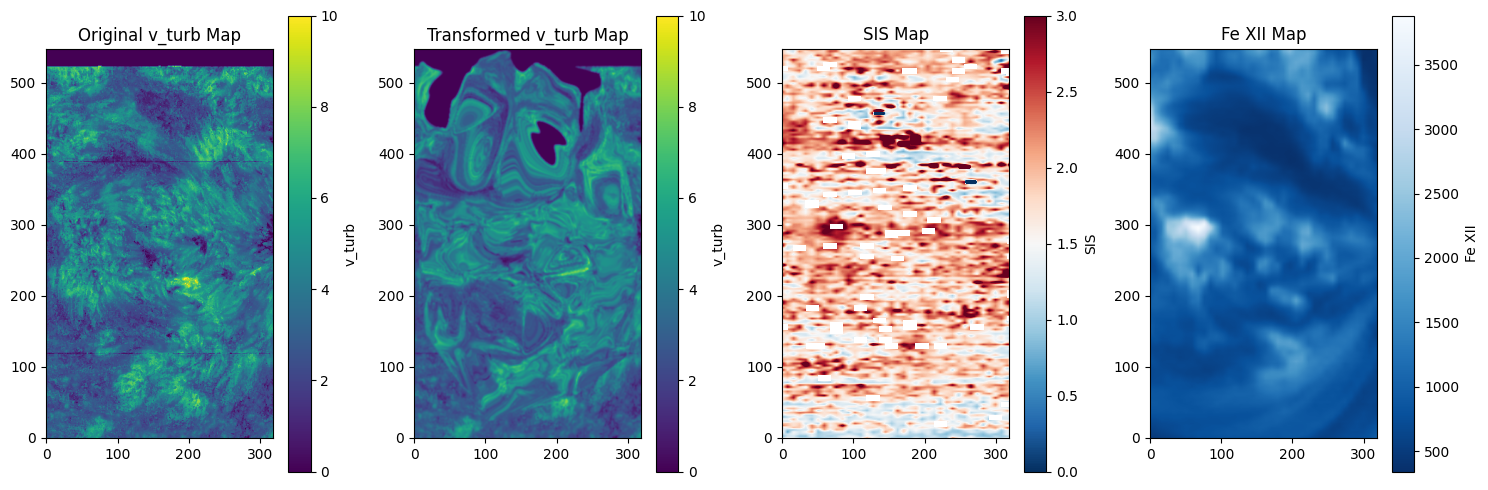

In [80]:
import json
import numpy as np
import sunpy.map
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Load the chromosphere to corona mapping
with open('chromo_to_coro_mapping.json', 'r') as f:
    chromo_to_coro_mapping = json.load(f)

# Create empty arrays to store the source and target coordinates
source_coords = []
target_coords = []
for chromo_key, coro_value in chromo_to_coro_mapping.items():
    chromo_x, chromo_y = map(int, chromo_key.split(','))
    coro_x, coro_y = map(int, coro_value.split(','))
    source_coords.append([chromo_x, chromo_y])
    target_coords.append([coro_x, coro_y])

source_coords = np.array(source_coords)
target_coords = np.array(target_coords)

# Calculate the displacement vectors
displacement = target_coords - source_coords

# Create a grid of points covering the entire image
x = np.arange(0, v_turb_map.data.shape[1])
y = np.arange(0, v_turb_map.data.shape[0])
grid_x, grid_y = np.meshgrid(x, y)

# Interpolate the displacement vectors to create a full vector field
dx = griddata(source_coords, displacement[:, 0], (grid_x, grid_y), method='cubic', fill_value=np.nan)
dy = griddata(source_coords, displacement[:, 1], (grid_x, grid_y), method='cubic', fill_value=np.nan)

# Create a mask for regions with no field lines
no_fieldline_mask = np.isnan(dx) & np.isnan(dy)

# Apply Gaussian smoothing to the vector field, only where field lines exist
dx_smooth = np.where(~no_fieldline_mask, gaussian_filter(np.nan_to_num(dx), sigma=2), np.nan)
dy_smooth = np.where(~no_fieldline_mask, gaussian_filter(np.nan_to_num(dy), sigma=2), np.nan)

# Create maps for the x and y components of the vector field
dx_map = sunpy.map.Map(dx_smooth, v_turb_map.meta)
dy_map = sunpy.map.Map(dy_smooth, v_turb_map.meta)

# Function to apply the vector field to a map
def apply_vector_field(input_map, dx_map, dy_map):
    # Create coordinate arrays
    y, x = np.indices(input_map.data.shape)
    
    # Apply displacements only where field lines exist
    new_x = np.where(~np.isnan(dx_map.data), x + dx_map.data, x)
    new_y = np.where(~np.isnan(dy_map.data), y + dy_map.data, y)
    
    # Clip coordinates to ensure they're within bounds
    new_x = np.clip(new_x, 0, input_map.data.shape[1] - 1)
    new_y = np.clip(new_y, 0, input_map.data.shape[0] - 1)
    
    # Interpolate values at new coordinates
    new_data = griddata((y.ravel(), x.ravel()), input_map.data.ravel(), (new_y, new_x), method='linear', fill_value=np.nan)
    
    # Only smooth where field lines exist
    smoothed_data = np.where(~np.isnan(new_data), gaussian_filter(np.nan_to_num(new_data), sigma=1), np.nan)
    
    # Create a new map with the transformed and smoothed data
    new_map = sunpy.map.Map(smoothed_data, input_map.meta)
    
    return new_map

# Apply the vector field to v_turb_map
transformed_v_turb_map = apply_vector_field(v_turb_map, dx_map, dy_map)

print("Vector field created and applied to v_turb_map.")
print("You can now use 'transformed_v_turb_map' to visualize or further process the transformed data.")

# # Plot the vector field map
# plt.figure(figsize=(12, 10))
# plt.imshow(v_turb_map.data, cmap='viridis', origin='lower')
# plt.quiver(grid_x[::20, ::20], grid_y[::20, ::20], 
#            dx_smooth[::20, ::20], dy_smooth[::20, ::20], 
#            angles='xy', scale_units='xy', scale=0.1, color='r')
# plt.title('Vector Field Map (Only where field lines exist)')
# plt.colorbar(label='v_turb')
# plt.xlabel('X (pixels)')
# plt.ylabel('Y (pixels)')
# plt.show()

# Plot the original v_turb map, transformed v_turb map, and sis map
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

im1 = ax1.imshow(v_turb_map.data, cmap='viridis', origin='lower', vmin=0, vmax=10)
ax1.set_title('Original v_turb Map')
plt.colorbar(im1, ax=ax1, label='v_turb')

im2 = ax2.imshow(transformed_v_turb_map.data, cmap='viridis', origin='lower', vmin=0, vmax=10)
ax2.set_title('Transformed v_turb Map')
plt.colorbar(im2, ax=ax2, label='v_turb')

im3 = ax3.imshow(sis_map.data, cmap='RdBu_r', origin='lower', vmin=0,vmax=3)
ax3.set_title('SIS Map')
plt.colorbar(im3, ax=ax3, label='SIS')

im4 = ax4.imshow(fe_12_map.data, cmap='Blues_r', origin='lower')
ax4.set_title('Fe XII Map')
plt.colorbar(im4, ax=ax4, label='Fe XII')

plt.tight_layout()
plt.show()


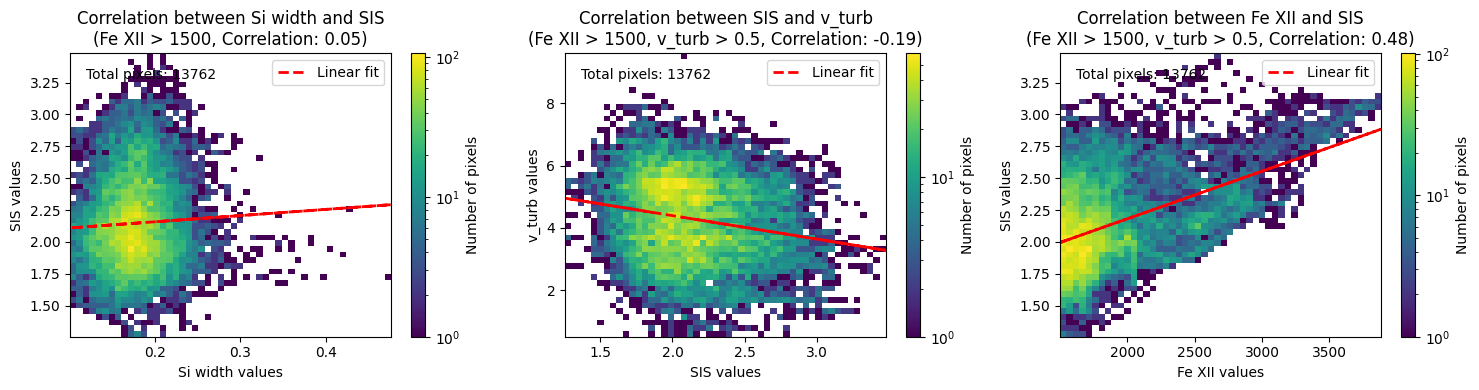

In [103]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm
import numpy as np

# Create masks for valid data points
fe_12_mask = fe_12_map.data > 1500
sis_mask = ~np.isnan(sis_map.data)
si_width_mask = (~np.isnan(width_map.data)) & (width_map.data > 0.1)
v_turb_mask = (~np.isnan(v_turb_map.data)) & (v_turb_map.data > 0.5)

# Combine all masks
combined_mask = fe_12_mask & sis_mask & si_width_mask & v_turb_mask

# Extract valid data points
sis_values = sis_map.data[combined_mask]
si_width_values = width_map.data[combined_mask]
v_turb_values = v_turb_map.data[combined_mask]
fe_12_values = fe_12_map.data[combined_mask]

# Calculate correlation coefficients
correlation_si_width_sis, _ = pearsonr(si_width_values, sis_values)
correlation_sis_vturb, _ = pearsonr(sis_values, v_turb_values)
correlation_fe12_sis, _ = pearsonr(fe_12_values, sis_values)

# Create the scatter plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Si width vs SIS plot
h1 = ax1.hist2d(si_width_values, sis_values, bins=50, cmap='viridis', norm=LogNorm())
fig.colorbar(h1[3], ax=ax1, label='Number of pixels')

# Calculate and plot the linear fit for Si width vs SIS
coeffs1 = np.polyfit(si_width_values, sis_values, 1)
poly1 = np.poly1d(coeffs1)
ax1.plot(si_width_values, poly1(si_width_values), color='r', linestyle='--', linewidth=2, label='Linear fit')

ax1.set_xlabel('Si width values')
ax1.set_ylabel('SIS values')
ax1.set_title(f'Correlation between Si width and SIS\n'
              f'(Fe XII > 1500, Correlation: {correlation_si_width_sis:.2f})')

ax1.text(0.05, 0.95, f'Total pixels: {len(sis_values)}', 
         transform=ax1.transAxes, verticalalignment='top')

ax1.legend()

# SIS vs v_turb plot
h2 = ax2.hist2d(sis_values, v_turb_values, bins=50, cmap='viridis', norm=LogNorm())
fig.colorbar(h2[3], ax=ax2, label='Number of pixels')

# Calculate and plot the linear fit for SIS vs v_turb
coeffs2 = np.polyfit(sis_values, v_turb_values, 1)
poly2 = np.poly1d(coeffs2)
ax2.plot(sis_values, poly2(sis_values), color='r', linestyle='--', linewidth=2, label='Linear fit')

ax2.set_xlabel('SIS values')
ax2.set_ylabel('v_turb values')
ax2.set_title(f'Correlation between SIS and v_turb\n'
              f'(Fe XII > 1500, v_turb > 0.5, Correlation: {correlation_sis_vturb:.2f})')

ax2.text(0.05, 0.95, f'Total pixels: {len(sis_values)}', 
         transform=ax2.transAxes, verticalalignment='top')

ax2.legend()

# Fe XII vs SIS plot
h3 = ax3.hist2d(fe_12_values, sis_values, bins=50, cmap='viridis', norm=LogNorm())
fig.colorbar(h3[3], ax=ax3, label='Number of pixels')

# Calculate and plot the linear fit for Fe XII vs SIS
coeffs3 = np.polyfit(fe_12_values, sis_values, 1)
poly3 = np.poly1d(coeffs3)
ax3.plot(fe_12_values, poly3(fe_12_values), color='r', linestyle='--', linewidth=2, label='Linear fit')

ax3.set_xlabel('Fe XII values')
ax3.set_ylabel('SIS values')
ax3.set_title(f'Correlation between Fe XII and SIS\n'
              f'(Fe XII > 1500, v_turb > 0.5, Correlation: {correlation_fe12_sis:.2f})')

ax3.text(0.05, 0.95, f'Total pixels: {len(sis_values)}', 
         transform=ax3.transAxes, verticalalignment='top')

ax3.legend()

plt.tight_layout()
plt.show()


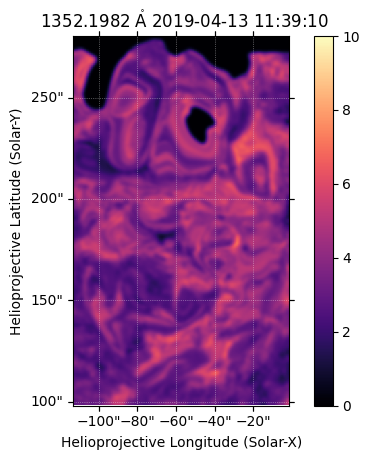

In [57]:
transformed_v_turb_map.peek(vmin=0, vmax=10, cmap='magma')

In [48]:
import json
import numpy as np
import sunpy.map
from scipy.ndimage import generic_filter

# Load the chromosphere to corona mapping
with open('chromo_to_coro_mapping.json', 'r') as f:
    chromo_to_coro_mapping = json.load(f)

# Create a blank map for the corona using the same dimensions and metadata as width_map
corona_map_data = np.full_like(width_map.data, np.nan)
corona_map = sunpy.map.Map(corona_map_data, width_map.meta)

def get_surrounding_pixels(x, y, data):
    return data[max(0, y-1):min(data.shape[0], y+50), 
                max(0, x-1):min(data.shape[1], x+50)].flatten()

# Iterate through the chromosphere to corona mapping
for chromo_key, coro_value in chromo_to_coro_mapping.items():
    # Extract chromosphere pixel coordinates
    chromo_x, chromo_y = map(int, chromo_key.split(','))
    
    # Extract corona pixel coordinates
    coro_x, coro_y = map(int, coro_value.split(','))
    
    # Get the surrounding 9 pixels from v_turb_map
    surrounding_values = get_surrounding_pixels(chromo_x, chromo_y, v_turb_map.data)
    
    # Propagate these values to the surrounding 9 pixels in the corona
    for dy in range(-1, 2):
        for dx in range(-1, 2):
            corona_y, corona_x = coro_y + dy, coro_x + dx
            if 0 <= corona_y < corona_map_data.shape[0] and 0 <= corona_x < corona_map_data.shape[1]:
                if (dy+1)*3 + (dx+1) < len(surrounding_values):
                    corona_map_data[corona_y, corona_x] = surrounding_values[(dy+1)*3 + (dx+1)]
                else:
                    corona_map_data[corona_y, corona_x] = np.nan

# Apply np.nanmean to handle overlapping pixels
def nanmean_filter(values):
    return np.nanmean(values)

corona_map_data = generic_filter(corona_map_data, nanmean_filter, size=3, mode='constant', cval=np.nan)

corona_map = sunpy.map.Map(corona_map_data, v_turb_map.meta)

# Now corona_map contains the propagated chromospheric observation with improved resolution


/var/folders/6w/c91jbrwd1k501xpqgh_czqbmvjj465/T/ipykernel_69508/2609267978.py:41: RuntimeWarning: Mean of empty slice
  return np.nanmean(values)


In [49]:
len(np.where(~np.isnan(corona_map_data)))

2

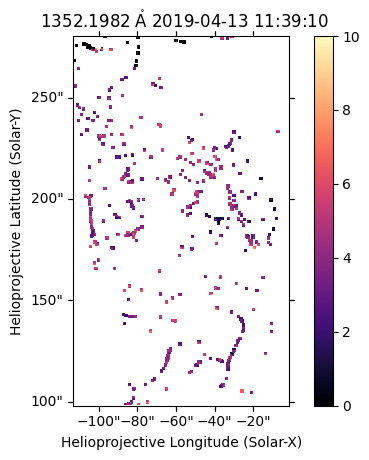

In [50]:
corona_map.peek(vmin=0, vmax=10, cmap='magma')

In [ ]:

# Optionally, you can visualize the result
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

v_turb_map.plot(axes=ax1, title='Original v_turb_map')
corona_map.plot(axes=ax2, title='Propagated Corona Map')

plt.tight_layout()
plt.show()

print("Chromospheric observation propagated to corona.")


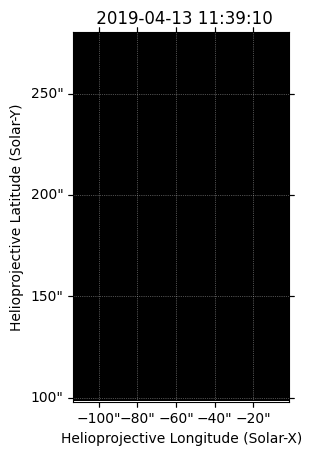

In [20]:
blank_map.plot()

100%|██████████| 189/189 [00:01<00:00, 186.03it/s]


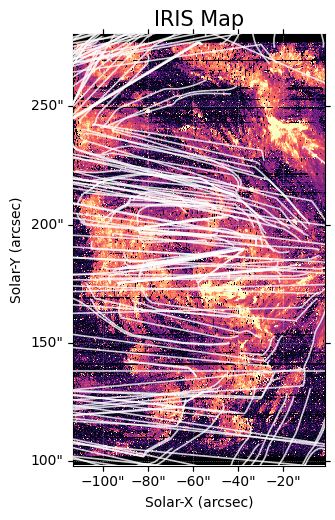

In [153]:
fig = plt.figure(figsize=(5,5))
for i,m in enumerate([width_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=0.25,cmap='magma')
    # m.plot()
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=15)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=10)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=10)
    ax.tick_params(axis='both', labelsize=10)
    # for c in tqdm(lines[::4]):
    #     ax.plot_coord(c, lw=3.3, color='white',alpha=.5)
    # for c in tqdm(long_lines[::2]):
    #     ax.plot_coord(c, lw=3.3, color='green',alpha=.8)
    for c in tqdm(chromo2coronal_lines[::3]):
        coords = c
        if coords.shape[0] > 0:  # Only plot if there are coordinates
            # Change the observer time of the coordinates to match the AIA map
            coords_updated = change_obstime(coords, m.date)
            ax.plot_coord(coords_updated, lw=1.2, color='white',alpha=.8)
    # for c in tqdm(long_lines[0]):
    #     ax.plot_coord(c, lw=5, color='black',alpha=.8)

    ax.axis(bounds)
# fig.savefig('Daves_IRIS_paper_PFSS.pdf',dpi=150)
plt.tight_layout(pad=0)
plt.show()

In [156]:
for f in all_lines:
    asc_loc, desc_loc = find_and_split_locations(f.radius, min_height=chromo_height, max_height=coronal_height)
    
    if asc_loc is not None and len(asc_loc) > 0:
        # Ascending part (footpoint to max height)
        chromo2coronal_lines.append(skycoord_constructor(f, f.lon[asc_loc], f.lat[asc_loc], f.radius[asc_loc]))
    
    if desc_loc is not None and len(desc_loc) > 0:
        # Descending part (max height to other footpoint)
        chromo2coronal_lines.append(skycoord_constructor(f, f.lon[desc_loc], f.lat[desc_loc], f.radius[desc_loc]))

100%|██████████| 283/283 [00:03<00:00, 71.82it/s]


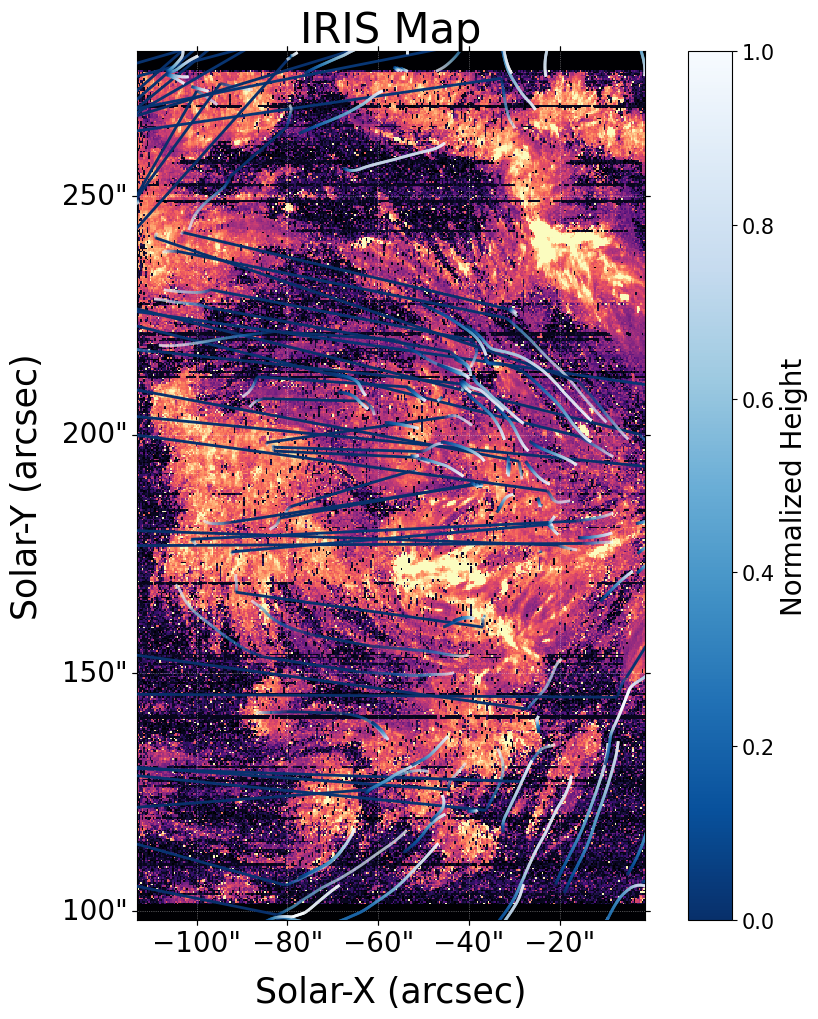

In [161]:

fig = plt.figure(figsize=(10,10))
for i,m in enumerate([width_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=0.25,cmap='magma')
    
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=30)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=25)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    
    for c in tqdm(chromo2coronal_lines[::10]):
        # Get the heights of the field line
        heights = c.radius.value
        
        # Normalize the heights to [0, 1] for colormapping
        norm_heights = (heights - heights.min()) / (heights.max() - heights.min())
        
        # Project the coordinates onto the map
        x, y = m.wcs.world_to_pixel(c)
        
        # Create a line collection for efficient plotting
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, cmap='Blues', norm=plt.Normalize(0, 1))
        lc.set_array(norm_heights)
        lc.set_linewidth(2)  # Reduced line width for better visibility
        
        ax.add_collection(lc)
    
    ax.axis(bounds)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='Blues_r', norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Normalized Height')
    cbar.set_label('Normalized Height', fontsize=20)
    cbar.ax.tick_params(labelsize=15)

plt.tight_layout(pad=0)
plt.show()

100%|██████████| 283/283 [00:07<00:00, 39.64it/s]


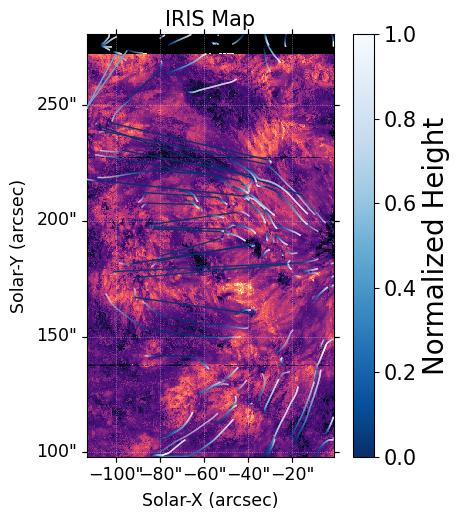

In [157]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.collections import LineCollection
from astropy import units as u

fig = plt.figure(figsize=(5,5))
for i,m in enumerate([v_turb_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=10,cmap='magma')
    
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=15)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=12.5)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=12.5)
    ax.tick_params(axis='both', labelsize=12.5)
    
    for c in tqdm(chromo2coronal_lines[::10]):
        # Trim the fieldline to only include points within the map
        x, y = m.wcs.world_to_pixel(c)
        within_map = (x >= bounds[0]) & (x <= bounds[1]) & (y >= bounds[2]) & (y <= bounds[3])
        c_trimmed = c[within_map]
        
        if len(c_trimmed) < 2:
            continue  # Skip if the trimmed line has less than 2 points
        
        # Get the heights of the trimmed field line
        heights = c_trimmed.radius.value
        
        # Find the index of the maximum height
        max_height_index = np.argmax(heights)
        
        # Split the line into ascending and descending parts
        ascending = c_trimmed[:max_height_index+1]
        descending = c_trimmed[max_height_index:]
        
        for part in [ascending, descending]:
            if len(part) < 2:
                continue
            
            # Normalize the heights to [0, 1] for colormapping
            part_heights = part.radius.value
            norm_heights = (part_heights - part_heights.min()) / (part_heights.max() - part_heights.min())
            
            # Project the coordinates of the part onto the map
            x, y = m.wcs.world_to_pixel(part)
            
            # Create a line collection for efficient plotting
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            lc = LineCollection(segments, cmap='Blues', norm=plt.Normalize(0, 1))
            lc.set_array(norm_heights)
            lc.set_linewidth(1)
            
            ax.add_collection(lc)
    
    ax.axis(bounds)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='Blues_r', norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Normalized Height')
    cbar.set_label('Normalized Height', fontsize=20)
    cbar.ax.tick_params(labelsize=15)

plt.tight_layout(pad=0)
plt.show()

0it [00:00, ?it/s]


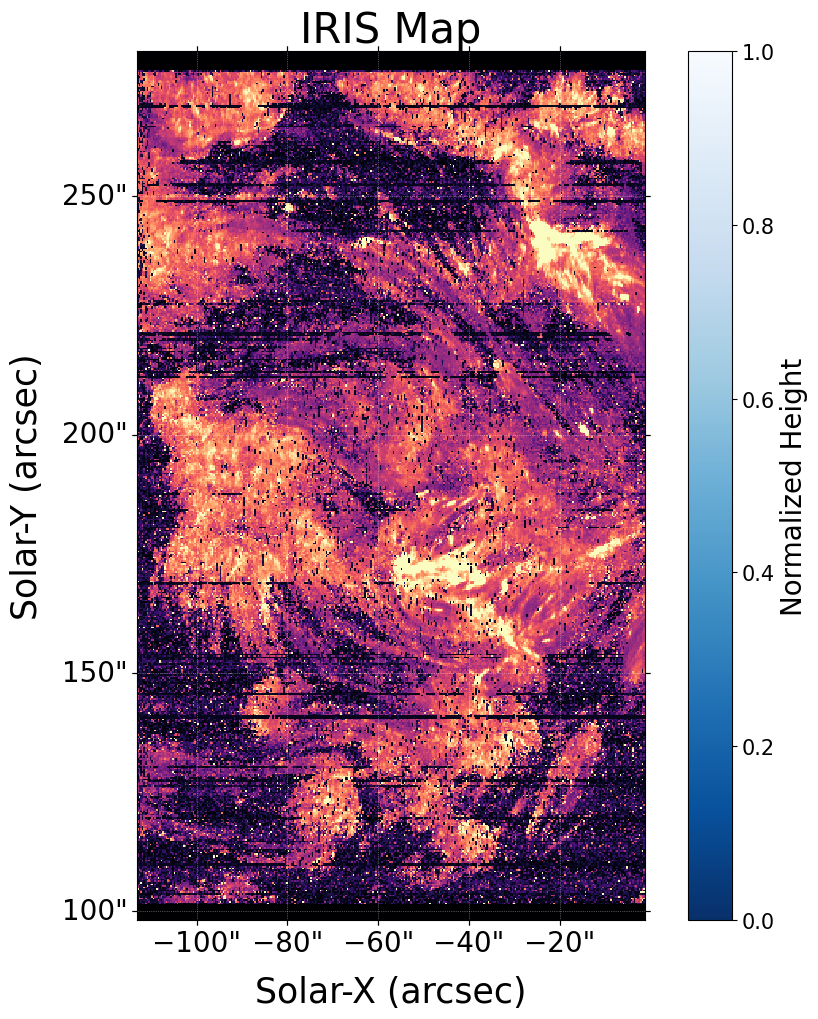

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.collections import LineCollection
from astropy import units as u
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord

def resample_field_line(line, num_points=100):
    t = np.linspace(0, 1, len(line.lon))
    t_new = np.linspace(0, 1, num_points)
    
    lon_interp = interp1d(t, line.lon.value, kind='linear')
    lat_interp = interp1d(t, line.lat.value, kind='linear')
    radius_interp = interp1d(t, line.radius.value, kind='linear')
    
    new_lon = lon_interp(t_new) * line.lon.unit
    new_lat = lat_interp(t_new) * line.lat.unit
    new_radius = radius_interp(t_new) * line.radius.unit
    
    return SkyCoord(lon=new_lon, lat=new_lat, radius=new_radius, frame=line.frame)

def interpolate_field_lines(chromo2coronal_lines, factor=3):
    resampled_lines = [resample_field_line(line) for line in chromo2coronal_lines]
    new_lines = []
    
    for i in range(len(resampled_lines) - 1):
        line1 = resampled_lines[i]
        line2 = resampled_lines[i + 1]
        
        # Interpolate between two existing lines
        for t in np.linspace(0, 1, factor+1)[1:-1]:
            new_lon = line1.lon + t * (line2.lon - line1.lon)
            new_lat = line1.lat + t * (line2.lat - line1.lat)
            new_radius = line1.radius + t * (line2.radius - line1.radius)
            new_lines.append(SkyCoord(lon=new_lon, lat=new_lat, radius=new_radius, frame=line1.frame))
    
    return resampled_lines + new_lines

# Interpolate more field lines
all_lines = interpolate_field_lines(chromo2coronal_lines)

fig = plt.figure(figsize=(10,10))
for i,m in enumerate([width_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=0.25,cmap='magma')
    
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=30)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=25)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    
    for c in tqdm(all_lines[::10]):
        # Get the heights of the field line
        heights = c.radius.value
        
        # Normalize the heights to [0, 1] for colormapping
        norm_heights = (heights - heights.min()) / (heights.max() - heights.min())
        
        # Project the coordinates onto the map
        x, y = m.wcs.world_to_pixel(c)
        
        # Create a line collection for efficient plotting
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, cmap='Blues', norm=plt.Normalize(0, 1))
        lc.set_array(norm_heights)
        lc.set_linewidth(2)  # Reduced line width for better visibility
        
        ax.add_collection(lc)
    
    ax.axis(bounds)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='Blues_r', norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Normalized Height')
    cbar.set_label('Normalized Height', fontsize=20)
    cbar.ax.tick_params(labelsize=15)

plt.tight_layout(pad=0)
plt.show()

0it [00:00, ?it/s]


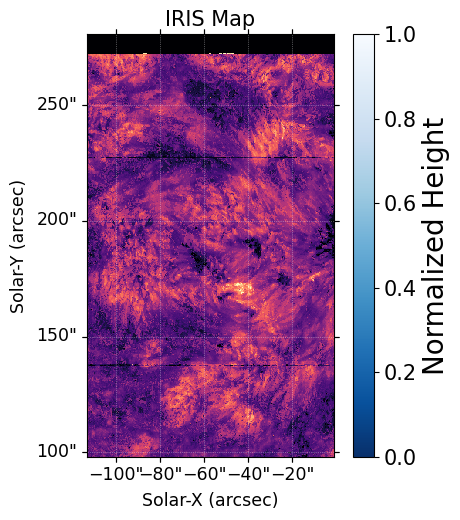

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.collections import LineCollection
from astropy import units as u

fig = plt.figure(figsize=(5,5))
for i,m in enumerate([v_turb_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=10,cmap='magma')
    
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=15)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=12.5)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=12.5)
    ax.tick_params(axis='both', labelsize=12.5)
    
    for c in tqdm(chromo2coronal_lines[::10]):
        # Get the heights of the field line
        heights = c.radius.value
        
        # Normalize the heights to [0, 1] for colormapping
        norm_heights = (heights - heights.min()) / (heights.max() - heights.min())
        
        # Project the coordinates onto the map
        x, y = m.wcs.world_to_pixel(c)
        
        # Create a line collection for efficient plotting
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, cmap='Blues', norm=plt.Normalize(0, 1))
        lc.set_array(norm_heights)
        lc.set_linewidth(3)
        
        ax.add_collection(lc)
    
    ax.axis(bounds)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='Blues_r', norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Normalized Height')
    cbar.set_label('Normalized Height', fontsize=20)
    cbar.ax.tick_params(labelsize=15)

plt.tight_layout(pad=0)
plt.show()

In [ ]:
def get_coronal_pixel_mapping(width_map, chromo2coronal_lines, chromo_height, coronal_height):
    """
    For each chromospheric height pixel, find the corresponding coronal pixel.
    
    Parameters:
    - width_map: The original map
    - chromo2coronal_lines: List of field lines
    - chromo_height: Chromospheric height
    - coronal_height: Coronal height
    
    Returns:
    - A 2D array of the same shape as width_map, where each element is a tuple (x, y)
      representing the pixel coordinates of the corresponding coronal point
    """
    
    # Create a grid for the original map
    y, x = np.mgrid[0:width_map.data.shape[0], 0:width_map.data.shape[1]]
    
    # Convert grid to world coordinates
    grid_coords = width_map.pixel_to_world(x * u.pix, y * u.pix)
    
    # Extract coordinates of field lines at chromospheric and coronal heights
    chromo_points = []
    coronal_points = []
    for line in chromo2coronal_lines:
        chromo_idx = np.argmin(np.abs(line.radius - chromo_height))
        coronal_idx = np.argmin(np.abs(line.radius - coronal_height))
        chromo_points.append([line.lon[chromo_idx].to(u.deg).value, line.lat[chromo_idx].to(u.deg).value])
        coronal_points.append([line.lon[coronal_idx].to(u.deg).value, line.lat[coronal_idx].to(u.deg).value])
    
    chromo_points = np.array(chromo_points)
    coronal_points = np.array(coronal_points)
    
    # Create KD-tree for efficient nearest neighbor search
    tree = cKDTree(chromo_points)
    
    # Reshape grid coordinates for KD-tree query
    grid_coords_flat = np.column_stack((grid_coords.lon.to(u.deg).value.ravel(), 
                                        grid_coords.lat.to(u.deg).value.ravel()))
    
    # Find nearest field line for each grid point
    _, indices = tree.query(grid_coords_flat)
    
    # Get corresponding coronal points
    coronal_lon = coronal_points[indices, 0].reshape(width_map.data.shape)
    coronal_lat = coronal_points[indices, 1].reshape(width_map.data.shape)
    
    # Convert coronal coordinates to pixel coordinates
    coronal_coords = SkyCoord(coronal_lon*u.deg, coronal_lat*u.deg, frame=width_map.coordinate_frame)
    coronal_pixels = width_map.world_to_pixel(coronal_coords)
    
    # Create the mapping array
    mapping = np.dstack((coronal_pixels.x.value.astype(int), coronal_pixels.y.value.astype(int)))
    
    return mapping

# Example usage:
chromo_height = 1.01 * u.R_sun
coronal_height = 1.1 * u.R_sun
coronal_pixel_mapping = get_coronal_pixel_mapping(width_map, chromo2coronal_lines, chromo_height, coronal_height)

print(f"Mapping shape: {coronal_pixel_mapping.shape}")
print(f"Example mapping for pixel (0,0): {coronal_pixel_mapping[0,0]}")


ValueError: data must be of shape (n, m), where there are n points of dimension m

In [14]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator
from astropy.coordinates import SkyCoord
from sunpy.map import Map
from astropy import units as u
from scipy.spatial import cKDTree

def propagate_map(width_map, chromo2coronal_lines, min_height, max_height):
    print(f"Original map shape: {width_map.data.shape}")
    
    # Create a grid at the minimum height
    y, x = np.mgrid[0:width_map.data.shape[0], 0:width_map.data.shape[1]]
    
    # Convert grid to world coordinates
    grid_coords = width_map.pixel_to_world(x * u.pix, y * u.pix)
    
    # Extract coordinates of field lines at min and max heights
    field_lines_min = []
    field_lines_max = []
    for line in chromo2coronal_lines:
        min_idx = np.argmin(np.abs(line.radius - min_height))
        max_idx = np.argmin(np.abs(line.radius - max_height))
        field_lines_min.append([line.lon[min_idx].to(u.deg).value, line.lat[min_idx].to(u.deg).value])
        field_lines_max.append([line.lon[max_idx].to(u.deg).value, line.lat[max_idx].to(u.deg).value])
    
    field_lines_min = np.array(field_lines_min)
    field_lines_max = np.array(field_lines_max)
    
    print(f"Number of field lines: {len(field_lines_min)}")
    
    # Create KD-tree for efficient nearest neighbor search
    tree = cKDTree(field_lines_min)
    
    # Reshape grid coordinates for KD-tree query
    grid_coords_flat = np.column_stack((grid_coords.Tx.to(u.deg).value.ravel(), 
                                        grid_coords.Ty.to(u.deg).value.ravel()))
    
    # Find nearest field line for each grid point
    _, indices = tree.query(grid_coords_flat)
    
    # Interpolate values to max height
    max_lon = field_lines_max[indices, 0].reshape(width_map.data.shape)
    max_lat = field_lines_max[indices, 1].reshape(width_map.data.shape)
    
    # Convert max height coordinates back to pixel coordinates
    max_coords = SkyCoord(max_lon*u.deg, max_lat*u.deg, frame=width_map.coordinate_frame)
    max_x, max_y = width_map.world_to_pixel(max_coords)
    
    # Create a mask for valid coordinates
    valid_mask = (max_x.value >= 0) & (max_x.value < width_map.data.shape[1]) & (max_y.value >= 0) & (max_y.value < width_map.data.shape[0])
    
    # Prepare points and values for interpolation
    points = np.column_stack((x[valid_mask].ravel(), y[valid_mask].ravel()))
    values = width_map.data[valid_mask]
    
    # Use Nearest Neighbor interpolation
    interp = NearestNDInterpolator(points, values)
    
    # Interpolate values from original map to new coordinates
    new_map_data = interp((max_x.value, max_y.value))
    
    print(f"New map data shape: {new_map_data.shape}")
    print(f"Number of non-NaN values: {np.sum(~np.isnan(new_map_data))}")
    
    # Create new map at max height
    new_map = Map(new_map_data, width_map.meta)
    
    return new_map

# Usage
min_height = chromo_height * u.m
max_height = coronal_height * u.m
propagated_map = propagate_map(width_map, chromo2coronal_lines, min_height, max_height)

# Plot the new map
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=propagated_map)
im = propagated_map.plot(axes=ax, cmap='magma', vmin=0, vmax=0.25)
plt.colorbar(im)
ax.set_title('Propagated Map at Maximum Height', fontsize=20)
ax.set_xlabel('Solar-X (arcsec)', fontsize=15)
ax.set_ylabel('Solar-Y (arcsec)', fontsize=15)
plt.show()

Original map shape: (548, 320)
Number of field lines: 0


ValueError: data must be of shape (n, m), where there are n points of dimension m

In [187]:
propagated_map.data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [178]:
width_map.data.shape

(548, 320)

In [179]:
548*320

175360

In [171]:
print(chromo2coronal_lines[0].radius.unit)

m


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

0it [00:00, ?it/s]


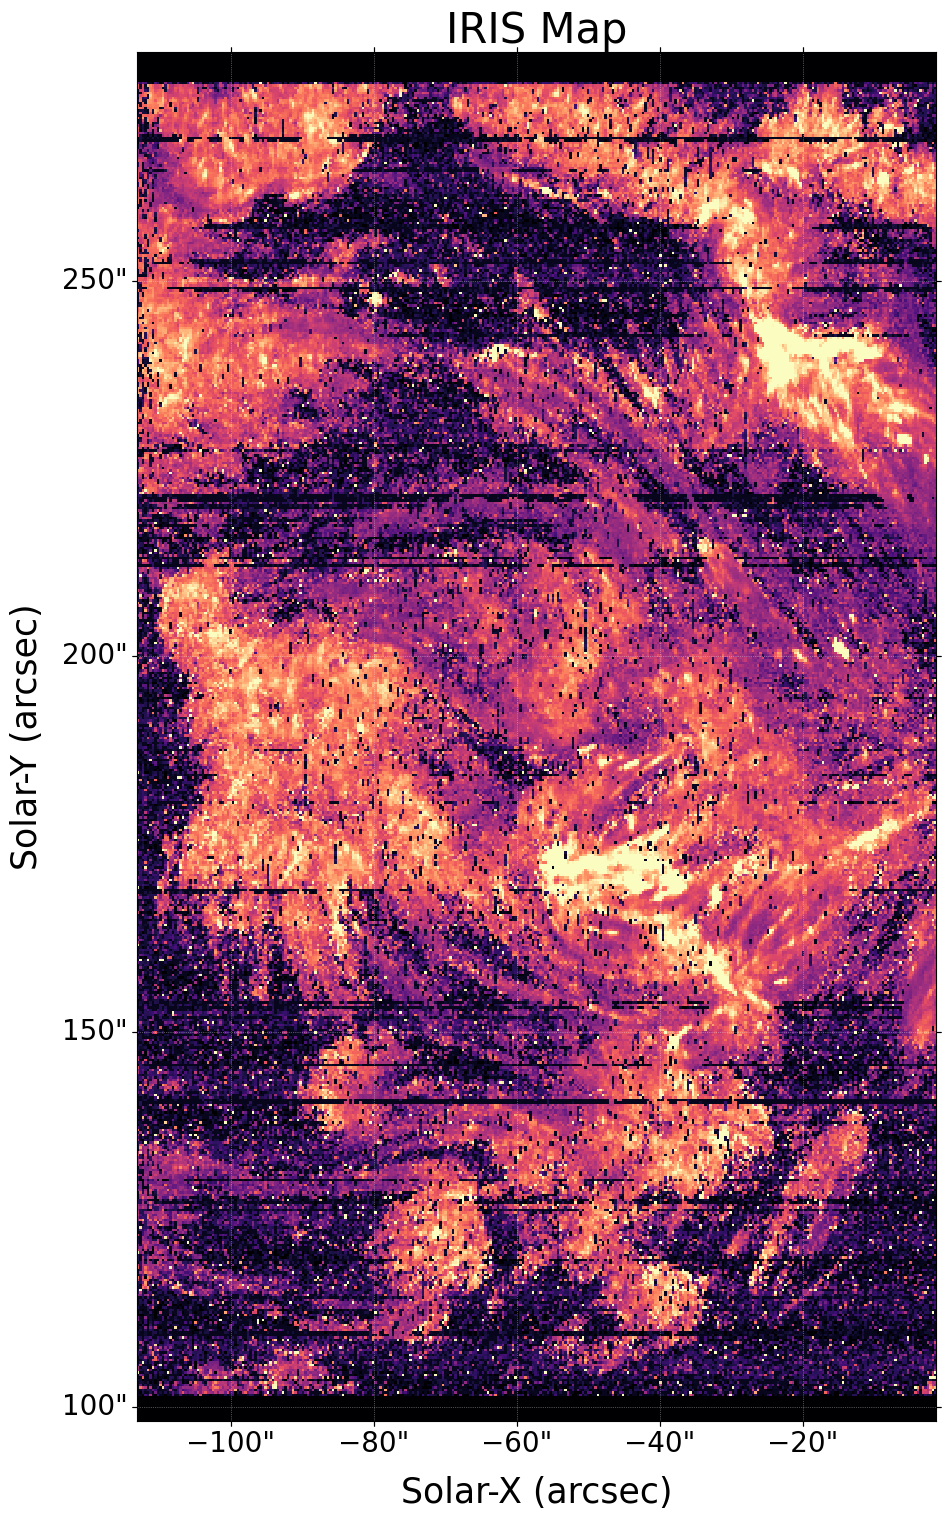

In [30]:
fig = plt.figure(figsize=(30,15))
for i,m in enumerate([width_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=0.25,cmap='magma')
    # m.plot()
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=30)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=25)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    # for c in tqdm(lines[::4]):
    #     ax.plot_coord(c, lw=3.3, color='white',alpha=.5)
    # for c in tqdm(long_lines[::2]):
    #     ax.plot_coord(c, lw=3.3, color='green',alpha=.8)
    for c in tqdm(chromo2coronal_lines):
        ax.plot_coord(c, lw=3, color='white',alpha=1)
    # for c in tqdm(long_lines[0]):
    #     ax.plot_coord(c, lw=5, color='black',alpha=.8)

    ax.axis(bounds)
# fig.savefig('Daves_IRIS_paper_PFSS.pdf',dpi=150)
plt.tight_layout(pad=0)
plt.show()

0it [00:00, ?it/s]


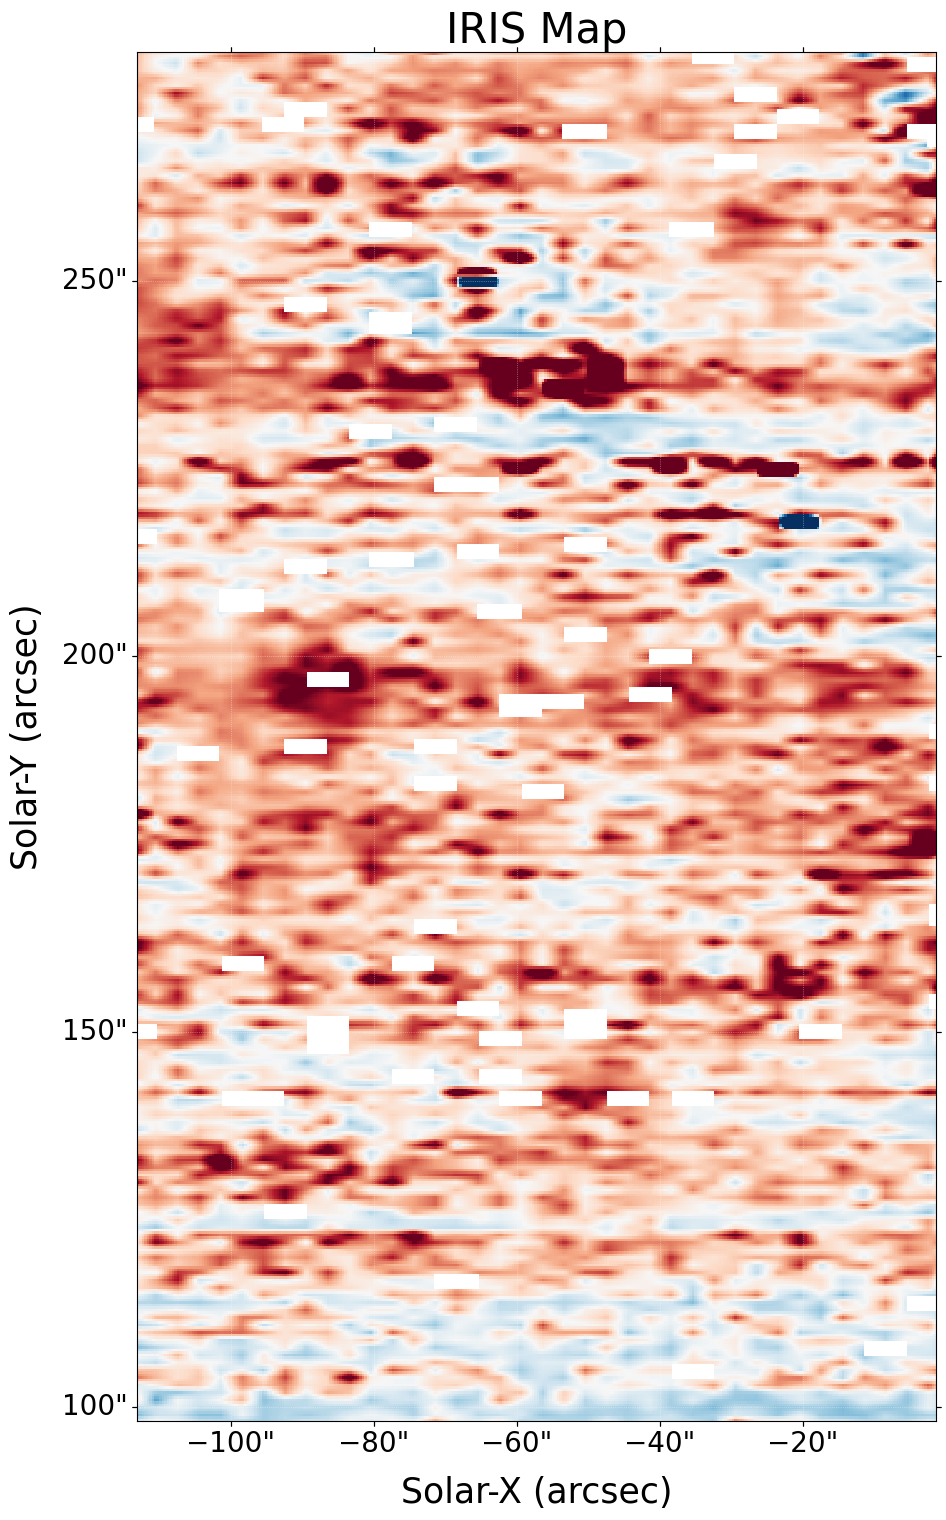

In [31]:
fig = plt.figure(figsize=(30,15))
for i,m in enumerate([sis_map]):
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,vmin=0, vmax=3,cmap='RdBu_r')
    # m.plot()
    bounds = ax.axis()
    ax.set_title('IRIS Map', fontsize=30)
    ax.set_xlabel('Solar-X (arcsec)', fontsize=25)
    ax.set_ylabel('Solar-Y (arcsec)', fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    # for c in tqdm(lines[::4]):
    #     ax.plot_coord(c, lw=3.3, color='white',alpha=.5)
    # for c in tqdm(long_lines[::2]):
    #     ax.plot_coord(c, lw=3.3, color='green',alpha=.8)
    for c in tqdm(coronal_lines[::2]):
        ax.plot_coord(c, lw=1.2, color='black',alpha=.8)
    # for c in tqdm(long_lines[0]):
    #     ax.plot_coord(c, lw=5, color='black',alpha=.8)

    ax.axis(bounds)
# fig.savefig('Daves_IRIS_paper_PFSS.pdf',dpi=150)
plt.tight_layout(pad=0)
plt.show()

In [80]:
all_lines[0]

<SkyCoord (HeliographicCarrington: obstime=2019-04-13T11:39:10.870, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2019-04-13T11:39:10.870, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (120.06752016, -5.75319862, 1.49997662e+11)>): (lon, lat, radius) in (deg, deg, m)
    [(291.33975338, 0.24990247, 6.95700512e+08),
     (291.34713493, 0.24858186, 6.95702136e+08),
     (291.35451474, 0.24725046, 6.95703615e+08),
     (291.36189284, 0.24590854, 6.95704948e+08),
     (291.36926925, 0.24455638, 6.95706130e+08),
     (291.37664398, 0.2431943 , 6.95707159e+08),
     (291.38401707, 0.24182261, 6.95708031e+08),
     (291.39138854, 0.24044164, 6.95708744e+08),
     (291.39875843, 0.23905175, 6.95709293e+08),
     (291.40612678, 0.23765332, 6.95709677e+08),
     (291.41349362, 0.23624674, 6.95709891e+08),
     (291.420859  , 0.23483241, 6.95709931e+08),
     (291.42822297, 0.23341079, 6.95709795e+08),
     (291.43558557, 0.23198231, 6.95709479e+08),
     (29

In [ ]:
for f in short_lines:
    loc = find_locations(f.radius, min_height=filter_height)
    if len(loc[0]) > 0:
        filtered_short_lines.append(skycoord_constructor(f, f.lon[loc], f.lat[loc], f.radius[loc]))